In [1]:
# set same dependency environment to ./Utils/Tracker.py, so python files in this script can access the same environment as Tracker.py
import sys
sys.path.append(r'D:\CodeRepos\Lidar-Tracker\LiDAR_Tracker_Project_v3.1\Interface\Utils')

from DDBSCAN import Raster_DBSCAN
from LiDARBase import *
from GenBckFile import *
from SaveTrajectoryTools import save_result
from ExamPcapStartTime import get_pcap_start_time
import pandas as pd
import os
from p_tqdm import p_umap
from functools import partial
from threading import Thread,Event
import matplotlib.pyplot as plt

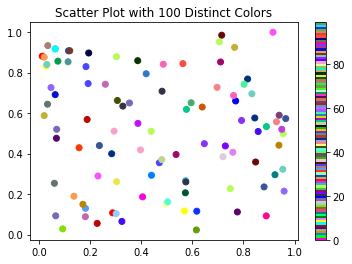

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from distinctipy import distinctipy
from matplotlib.colors import ListedColormap

# Generate 100 distinct colors
distinct_colors = distinctipy.get_colors(100)

# Create colormap
custom_cmap = ListedColormap(distinct_colors)

# Example usage with scatter plot
x = np.random.rand(100)
y = np.random.rand(100)
labels = np.random.randint(0, 100, 100)

plt.scatter(x, y, c=labels, cmap=custom_cmap)
plt.colorbar()
plt.title('Scatter Plot with 100 Distinct Colors')
plt.show()


In [76]:
pcap_file_path = r'D:\LiDAR_Data\US50ANDHighlands\2024-03-16-12-30-00.pcap'
tracking_parameter_dict = {
        'win_width': 13,
        'win_height': 7,
        'eps': 1,
        'min_samples': 10,
        'missing_thred': 5,
        'bck_radius': 0.2,
        'N' : 10,
        'd_thred' : 0.1,
    }
termination_event = Event()
thred_map = gen_bckmap(pcap_file_path, 
                        N = tracking_parameter_dict['N'],
                        d_thred = tracking_parameter_dict['d_thred'],
                        bck_n = 3,
                        termination_event = termination_event)
start_timestamp = get_pcap_start_time(pcap_file_path)
packets_gen = read_packets_offline(pcap_file_path)
frame_generator = parse_packets(packets_gen)

17987it [06:44, 44.48it/s]


In [80]:
UTC_time_diff = 0
if_save_point_cloud = True
point_cloud_path = r'D:\LiDAR_Data\Test'

In [238]:
mot = MOT(tracking_parameter_dict,thred_map)
mot.UTC_time_diff = UTC_time_diff
if if_save_point_cloud:
    mot.point_cloud_save_path = point_cloud_path
mot.start_timestamp = start_timestamp

In [239]:
while not mot.if_initialized:
    try:
        frame = next(frame_generator)
    except StopIteration:
        break
    mot.initialization(frame)

    if if_save_point_cloud:
        save_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,point_cloud_path,mot.CurFrame,mot.Tracking_pool)
    # break

In [422]:
frame = next(frame_generator)
mot.mot_tracking_step(frame)
# save_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,point_cloud_path,mot.CurFrame,mot.Tracking_pool)
fore_points = get_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,mot.Tracking_pool)
cur_frame = mot.CurFrame
cur_labeling_map = mot.cur_Labeling_map
cur_td_map = mot.cur_Td_map

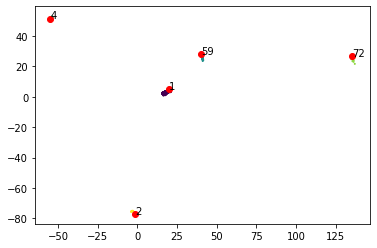

In [423]:
plt.scatter(fore_points[:,0],fore_points[:,1],s = 1,c = fore_points[:,3])
for key in mot.Tracking_pool.keys():
    if mot.Tracking_pool[key].label_seq[-1] != -1:
        plt.scatter(mot.Tracking_pool[key].mea_seq[-1][0][0][0],mot.Tracking_pool[key].mea_seq[-1][0][1][0],c = 'r')
        plt.text(mot.Tracking_pool[key].mea_seq[-1][0][0][0],mot.Tracking_pool[key].mea_seq[-1][0][1][0],str(key))
plt.show()

In [2]:
# point cloud is in .npy format [x,y,z,obj_label]
point_cloud_folder = r'D:\LiDAR_Data\US50ANDHighlands\test_point_cloud_out'
pc_folders = os.listdir(point_cloud_folder)
for folder in pc_folders:
    frame_names = os.listdir(os.path.join(point_cloud_folder, folder))
    total_point_clouds = []
    for frame in frame_names:
        point_cloud = np.load(os.path.join(point_cloud_folder, folder, frame))
        total_point_clouds.append(point_cloud)
    break
total_point_clouds_frame = np.concatenate(total_point_clouds, axis=0)

In [3]:
trajectory_data = pd.read_csv(r'D:\LiDAR_Data\US50ANDHighlands\test_traj_out\2024-03-16-12-30-00.csv')

In [30]:
y_max

-14.639944437326038

In [29]:
ID = 5
temp = fore_points[fore_points[:,3] == ID]
point_num = len(temp)
distance = np.sqrt(temp[:,0] ** 2 + temp[:,1] ** 2).mean()
# bounding box formed by temp
x_min = temp[:,0].min()
x_max = temp[:,0].max()
y_min = temp[:,1].min()
y_max = temp[:,1].max()
area = (x_max - x_min) * (y_max - y_min)
print(point_num,distance,area)

404 16.35410328724924 11.817856021012302


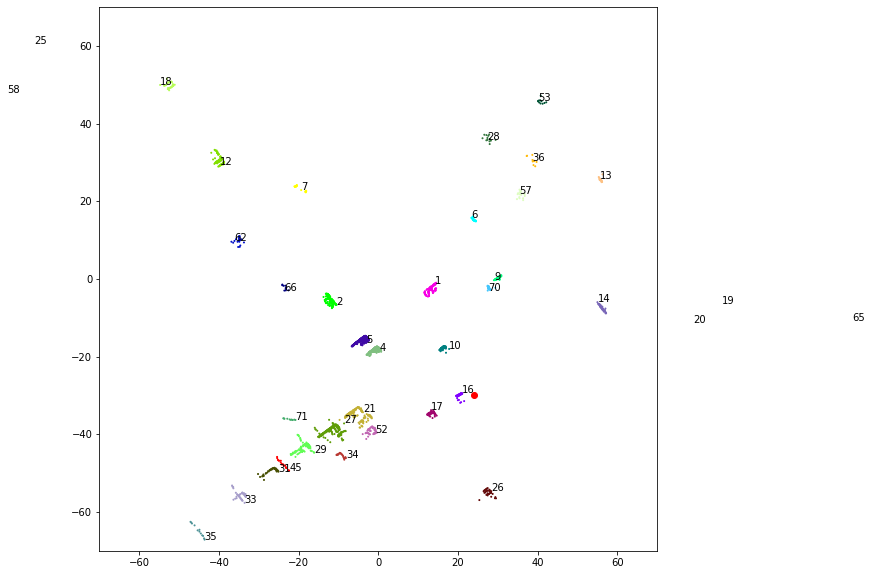

In [28]:
import numpy as np
import matplotlib.pyplot as plt

fore_points = np.load(r'D:\LiDAR_Data\Harvard_pc_out\2023-05-11-09-00-00\6.npy')
unique_ids = np.unique(fore_points[:,3])
plt.figure(figsize=(10,10))
plt.scatter(fore_points[:,0],fore_points[:,1],s = 1,c = fore_points[:,3],cmap = custom_cmap)
# annotate the id of each object
for id in unique_ids:
    id_points = fore_points[fore_points[:,3] == id]
    plt.text(id_points[0,0],id_points[0,1],str(int(id)))
plt.scatter(24.130,-29.841,c = 'r', label = 'Ref Point')
# x and y limits in +- 10 meters in the reference point
# plt.xlim(38.632 - 5,38.632 + 5)
# plt.ylim(-14.868 - 5,-14.868 + 5)
plt.xlim(-70,70)
plt.ylim(-70,70)
plt.show()

In [7]:
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np

In [5]:
date_list = ['2023-05-11-09-30-00','2023-05-11-08-30-00','2023-05-11-09-00-00','2023-05-11-07-30-00']

In [2]:
import numpy as np

In [22]:
36.8/360

0.10222222222222221

In [25]:
0.1022222222*np.pi*500**2 - 83164

-2878.854425714133

In [9]:
labels = []
point_nums = []
distances = []
areas = []
for table_str in date_list:
    table = pd.read_excel(r'D:\LiDAR_Data\Harvard_out_pc\NumClassification.xlsx',sheet_name = table_str)
    for i,row in tqdm(table.iterrows()):
        FrameIndex = row.FrameIndex
        Label = row.Label
        ObjID = row.ObjID
        fore_points = np.load(r'D:\LiDAR_Data\Harvard_out_pc\{}\{}.npy'.format(table_str,FrameIndex))
        temp = fore_points[fore_points[:,3] == ObjID]
        if len(temp) == 0:
            continue
        point_num = len(temp)
        distance = np.sqrt(temp[:,0] ** 2 + temp[:,1] ** 2).mean()
        rect = cv2.minAreaRect(temp[:,:2].astype('float32'))
        box = cv2.boxPoints(rect)
        # box = cv2.boxPoints(rect)
        b1 = np.sqrt(np.sum((box[1] - box[0])**2))
        b2 = np.sqrt(np.sum((box[2] - box[1])**2))
        area = b1 * b2
        labels.append(Label)
        point_nums.append(point_num)
        distances.append(distance)
        areas.append(area)
data = pd.DataFrame({'Label':labels,'PointNum':point_nums,'Distance':distances,'Area':areas})
    

2629it [00:00, 3412.32it/s]
2417it [00:00, 3417.78it/s]
3589it [00:01, 3412.88it/s]
119it [00:00, 3275.75it/s]


In [54]:
data.to_csv(r'D:\CodeRepos\Lidar-Tracker\LiDAR_Tracker_Project_v3.1\Interface\Utils\PedestrianCounter\Harvard_Training_Data.csv',index = False)

In [1]:
data = pd.read_csv(r'D:\CodeRepos\Lidar-Tracker\LiDAR_Tracker_Project_v3.1\Interface\Utils\PedestrianCounter\Harvard_Training_Data.csv')

NameError: name 'pd' is not defined

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Confusion Matrix:
[[802  44   7   0   2]
 [ 74 377  18   0   1]
 [ 12  48 176   0   2]
 [  0   0   1  34   0]
 [  1   1   2   2  94]]

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.94      0.92       855
           2       0.80      0.80      0.80       470
           3       0.86      0.74      0.80       238
           4       0.94      0.97      0.96        35
           5       0.95      0.94      0.94       100

    accuracy                           0.87      1698
   macro avg       0.89      0.88      0.88      1698
weighted avg       0.87      0.87      0.87      1698



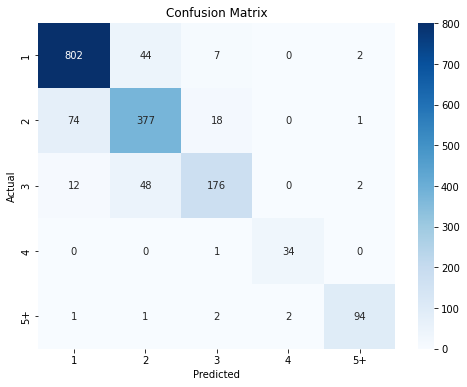

    Feature  Importance
2      Area    0.465941
0  PointNum    0.283943
1  Distance    0.250117


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Define features and target variable
X = np.array(df[['PointNum', 'Distance', 'Area']])
y = np.array(df['Label'])

# Categorize the target variable
y = np.where(y >= 5, 5, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the model
weights_dict = {}
for i in range(1,6):
    weights_dict[i] = len(y_train[y_train == i])
# rf_classifier = RandomForestClassifier(n_estimators=100, max_depth = 20,random_state=42,class_weight = weights_dict)
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth = 20,random_state=42,)

# Train the model
rf_classifier.fit(X_train, y_train)
# Predict on the test set
y_pred = rf_classifier.predict(X_test)
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5])

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Generate a classification report
class_report = classification_report(y_test, y_pred, labels=[1, 2, 3, 4, 5])
print("\nClassification Report:")
print(class_report)
# Define class labels
class_labels = ['1', '2', '3', '4','5+']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Get feature importances
importances = rf_classifier.feature_importances_
# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': ['PointNum', 'Distance', 'Area'],
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

In [ ]:
511.15+1.25 - 6.14+2.34-1.96+0.56-1.33

505.87

: 

In [28]:
300*350 - (50*300 + 50 * 250 + 100 *150)

62500

In [8]:
3 * 3600

10800

In [52]:
# save rf_classifier using pickle to 'D:\CodeRepos\Lidar-Tracker\LiDAR_Tracker_Project_v3.1\Interface\Utils\PedestrianCounter\counter.pkl'
import pickle
with open(r'D:\CodeRepos\Lidar-Tracker\LiDAR_Tracker_Project_v3.1\Interface\Utils\PedestrianCounter\counter.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

In [1546]:
rf_classifier = pickle.load(open(r'D:\CodeRepos\Lidar-Tracker\LiDAR_Tracker_Project_v3.1\Interface\Utils\PedestrianCounter\counter.pkl', 'rb'))


In [1537]:
test_traj = pd.read_csv(r'D:\LiDAR_Data\Harvard_out\2023-05-11-07-30-00.csv')

In [1555]:
# get index of class == 2
ped_index = test_traj[test_traj['Class'] == 2].index

In [1556]:
ped_index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            868076, 868077, 868078, 868079, 868080, 868082, 868083, 868084,
            868085, 868122],
           dtype='int64', length=67969)

In [1557]:
ped_num = rf_classifier.predict(np.array(test_traj.loc[ped_index,['Point_Cnt','Dis','Area']]))

In [1558]:
ped_num

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [1559]:
test_traj['Ped_Num'] = 0
test_traj.loc[ped_index,'Ped_Num'] = ped_num